# Test File For Transfer Learning, Image Classification NORMAL vs COVID

#### This is an example of transfer learning, this version needs more debuging.

In [0]:
#upload your kaggle.json file

from google.colab import files
files.upload()

In [2]:
!pip install kaggle
!pip install wget
!pip install pygithub

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=bfe4b2074d4254893f419a0eeb5cd5b660a0ab883482e6cd88158dc516203938
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 215kB 2.7MB/s 


In [0]:
import os
import glob
import wget
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from github import Github
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation,Dense, Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths

In [0]:
%tensorflow_version 2.x

In [6]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [0]:
COVID_ROOT = "https://github.com/ieee8023/covid-chestxray-dataset/blob/master/"
COVID_ROOT_RAW = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/"
COVID_IMAGE_FOLDER = os.path.join(COVID_ROOT, "images")
COVID_METADATA = os.path.join(COVID_ROOT_RAW, "metadata.csv")
COVID_LOCAL_FOLDER = os.path.join("COVID", "images")
KAGGLE_DATASET = "paultimothymooney/chest-xray-pneumonia"

GITHUB_USER = "ulatinaedupa"     # <YOUR USER>
GITHUB_PASS = "ulatina.edu.pa.1" # <YOUR PASSWORD>

In [0]:
def download_metadata(dspath = COVID_METADATA, pcpath = COVID_LOCAL_FOLDER):
  if not os.path.exists(pcpath):
    os.makedirs(pcpath)
  url = dspath
  root_folder = os.path.split(pcpath)[0]
  wget.download(url, root_folder)

In [0]:
download_metadata()

In [0]:
def download_folder_github(dspath   = COVID_IMAGE_FOLDER, pcpath   = COVID_LOCAL_FOLDER, 
                           youruser = GITHUB_USER,        yourpass = GITHUB_PASS):
  g = Github(youruser, yourpass)
  splitrepo  = dspath.split('/')[3:] 
  reponame   = os.path.join(splitrepo[0], splitrepo[1])
  foldername = splitrepo[-1]
 
  root_folder = pcpath
  repo = g.get_repo(reponame)
  contents = repo.get_contents(foldername)
  for content_file in contents:
    filename = content_file.path.split('/')[-1]
    url = os.path.join(dspath, filename + "?raw=true")
    wget.download(url, root_folder)


In [11]:
#download_folder_github()
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
!mv covid-chestxray-dataset/images COVID/

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 1369 (delta 74), reused 105 (delta 60), pack-reused 1227
Receiving objects: 100% (1369/1369), 210.59 MiB | 39.89 MiB/s, done.
Resolving deltas: 100% (644/644), done.
Checking out files: 100% (304/304), done.


In [0]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -rf kaggle.json

In [0]:
def download_kaggle_dataset(dspath = KAGGLE_DATASET, pcpath = COVID_LOCAL_FOLDER):
  api = KaggleApi()
  api.authenticate()
  pcpath = pcpath.split('/')[0]
  api.dataset_download_files(dspath, pcpath)

In [0]:
download_kaggle_dataset()

In [0]:
def unzip_kaggle_dataset(pcpath=COVID_LOCAL_FOLDER):
  root      = pcpath.split('/')[0]
  zipfilter = os.path.join(root, "*.zip")
  zipname   = glob.glob(zipfilter)[0]
  with ZipFile(zipname, 'r') as z:
    z.extractall(root)

In [0]:
unzip_kaggle_dataset()

In [0]:
!mv COVID/chest_xray/test COVID/
!mv COVID/chest_xray/train COVID/
!mv COVID/chest_xray/val COVID/
!rm -rf COVID/chest_xray
!mkdir COVID/test/COVID
!mkdir COVID/train/COVID
!mkdir COVID/val/COVID

In [18]:
df = pd.read_csv(COVID_METADATA, parse_dates=['date'])
df.head()

patientid  offset  ... other_notes  Unnamed: 27
0          2     0.0  ...         NaN          NaN
1          2     3.0  ...         NaN          NaN
2          2     5.0  ...         NaN          NaN
3          2     6.0  ...         NaN          NaN
4          4     0.0  ...         NaN          NaN

[5 rows x 28 columns]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               312 non-null    int64  
 1   offset                  225 non-null    float64
 2   sex                     273 non-null    object 
 3   age                     262 non-null    float64
 4   finding                 312 non-null    object 
 5   survival                92 non-null     object 
 6   intubated               48 non-null     object 
 7   intubation_present      43 non-null     object 
 8   went_icu                14 non-null     object 
 9   needed_supplemental_O2  3 non-null      object 
 10  extubated               3 non-null      object 
 11  temperature             22 non-null     float64
 12  pO2_saturation          33 non-null     float64
 13  leukocyte_count         9 non-null      float64
 14  neutrophil_count        2 non-null      fl

In [0]:
dflist = ["patientid", "offset", "view", "modality",
          "doi", "url", "license", "clinical_notes", "other_notes", "Unnamed: 27"]
df = df.drop(dflist, axis=1)

nii_gz = pd.Index(df.filename.str.endswith("nii.gz")) # get indexes of images (volumes) ended with nii.gz
indexes = df.index[nii_gz == True].tolist() # get the rows as list
df = df.drop(indexes)

df.age = df.age.fillna(df.age.median()) # assume prom age
df.sex = df.sex.fillna('Male') # we will assume NaN as males
df.survival = df.survival.fillna('Yes') # assume NaN not tagged as ok
df = df.replace({df.columns[0]: {'M': 'Male', 'F': 'Female'}}) # 
df = df.replace({df.columns[3]: {'Y': 'Yes', 'N': 'No'}})
df.reset_index(drop=True, inplace=True)


In [21]:
df.age.isnull().values.any(), df.sex.isnull().values.any(), df.survival.isnull().values.any()

(False, False, False)

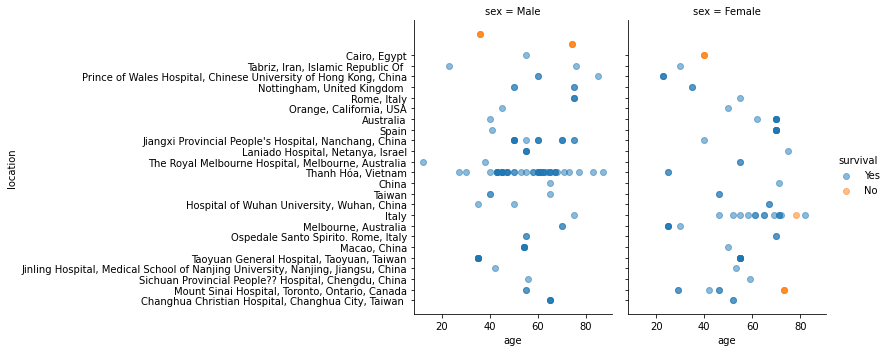

In [22]:
g = sns.FacetGrid(df, col="sex", hue="survival", height=5, aspect=1.2)
g.map(plt.scatter, "age", "location", alpha=0.5)
g.add_legend();
g.savefig("hospitals.pdf", dpi=300)

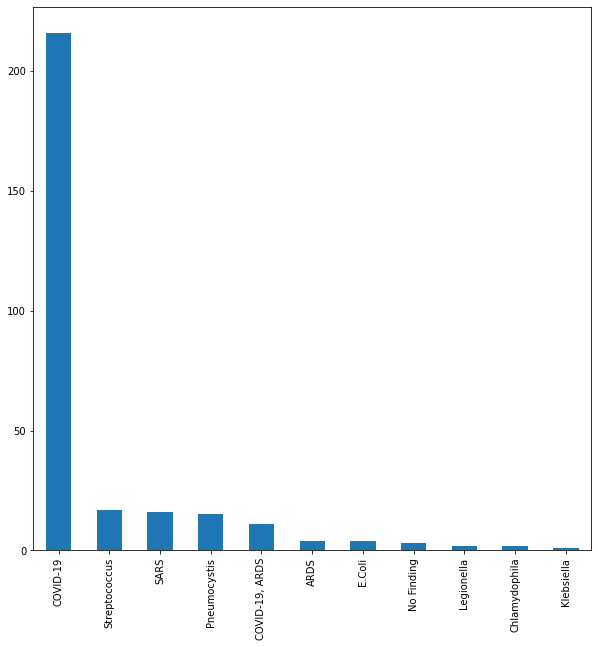

In [23]:
ax = df.finding.value_counts().plot(kind='bar', figsize=(10,10))
fig = ax.get_figure()
fig.savefig('BarPlot.pdf', dpi=300)

In [24]:
shortdf = df[df.finding == "COVID-19"]
shortdf.reset_index(drop=True, inplace=True)
print("Total COVID-19 = " + str(len(shortdf)))

Total COVID-19 = 216


In [0]:
images = shortdf.filename

Text(0.5, 0.98, 'COVID-19 Patients')

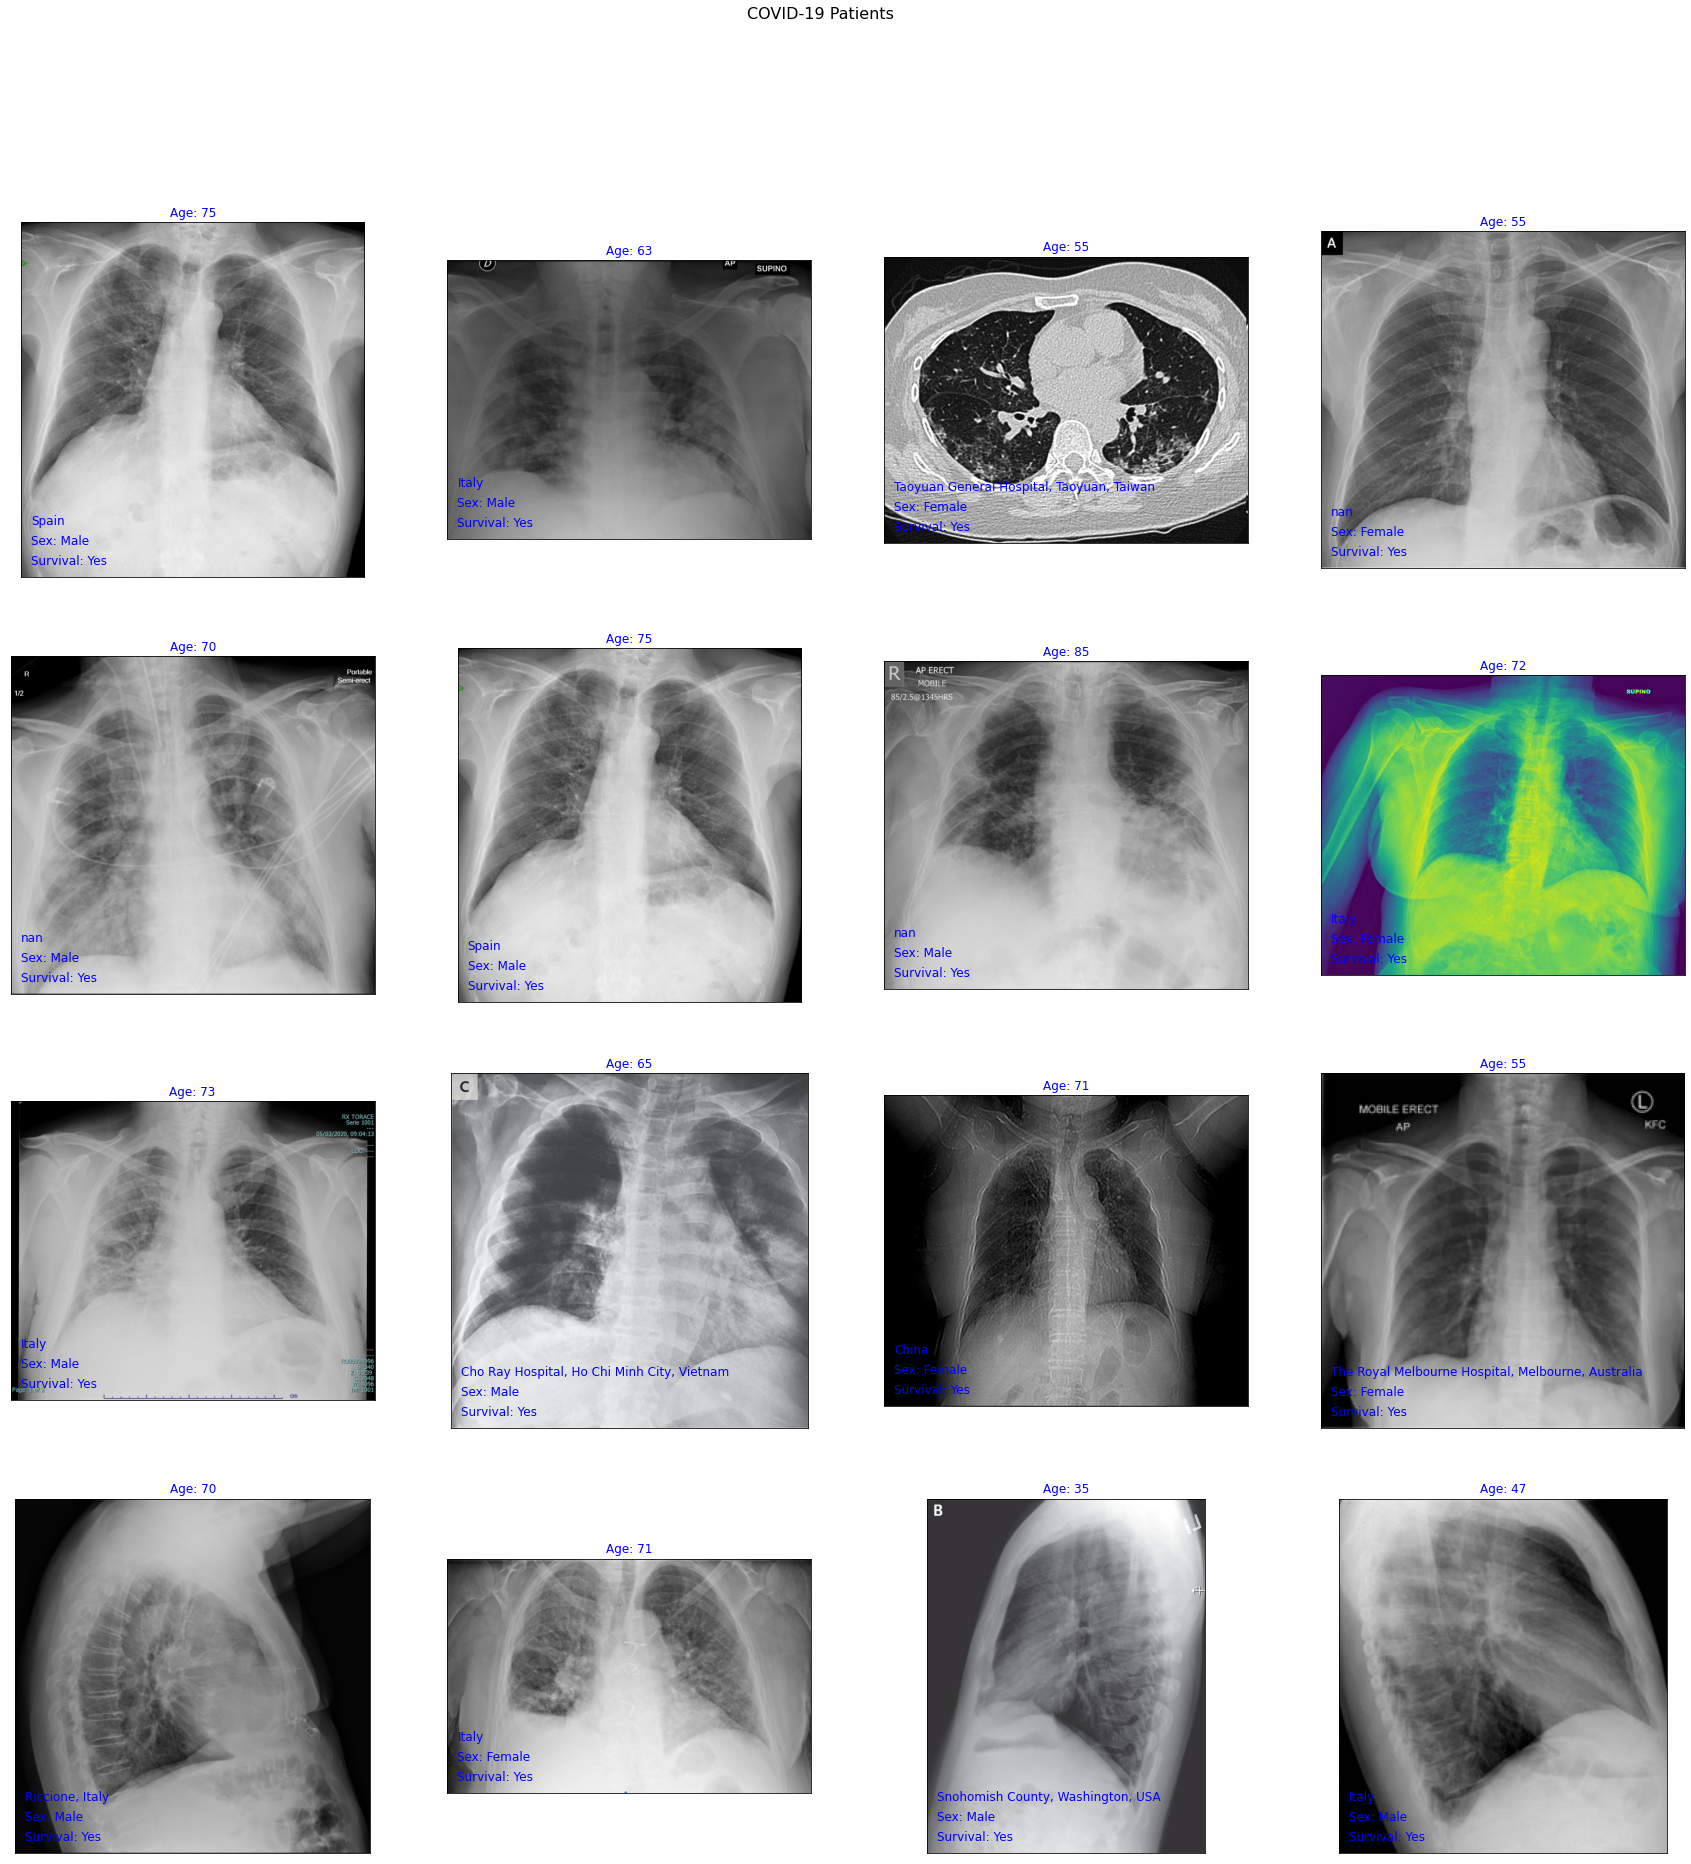

In [26]:
def annotate(text, ax, color, xytext):
    ax.annotate(text,
    xy=(0, 0), xycoords='axes fraction',
    xytext=xytext, textcoords='offset points',
    horizontalalignment='left',
    verticalalignment='bottom', color=color, size=12)

fig, ax = plt.subplots(figsize=(30, 30))

nrows = 4
ncols = 4

plt.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(nrows*ncols):
  axp = plt.subplot(nrows, ncols, i + 1)
  ix = np.random.randint(len(images))

  img = plt.imread('COVID/images/' + images[ix])
  
  Survived = "Survival: " + shortdf.survival[ix] 
  Sex      = "Sex: " + shortdf.sex[ix]
  Location = shortdf.location[ix]

  color = 'b'
  if shortdf.survival[ix] == 'No':
    color = 'r'

  annotate(Survived, axp, color, (10, 10))
  annotate(Sex, axp, color, (10, 30))
  annotate(Location, axp, color, (10, 50))
  
  plt.title("Age: " + str(int(shortdf.age[ix])), fontdict={"color":color})
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
fig.suptitle('COVID-19 Patients', fontsize=16)

In [0]:
fig.savefig('SARS-COV-2-Patients.pdf', dpi=300)

In [0]:
covid_images = []
covid_labels = []
label = 0
for i in images:
  image = np.array(plt.imread('COVID/images/' + images[ix]))
  covid_images.append(image)
  covid_labels.append(label)
covid_images = np.array(covid_images)
covid_labels = np.array(covid_labels)
covid_labels = np.reshape(covid_labels, (len(covid_labels), 1))

In [29]:
covid_images.shape, covid_labels.shape

((216, 1613, 1492, 3), (216, 1))

In [30]:
np.random.seed(42)
# From dataset to train and test
test_size = 0.2
Xtrain, Xtest, Ytrain, Ytest = train_test_split(covid_images, covid_labels,
                                            test_size = test_size, random_state=42)

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain,
                                      test_size = test_size/2, random_state=42)
Xtrain.shape, Xval.shape, Xtest.shape, Ytrain.shape, Yval.shape, Ytest.shape

((154, 1613, 1492, 3),
 (18, 1613, 1492, 3),
 (44, 1613, 1492, 3),
 (154, 1),
 (18, 1),
 (44, 1))

In [0]:
def img_arr_to_folder(img_arr, folder):
    for i in range(img_arr.shape[0]):
      img = img_arr[i]
      fname = os.path.join(folder, str(i) + ".jpg")
      plt.imsave(fname, img)

folder = "COVID/train/COVID"
img_arr_to_folder(Xtrain, folder)

folder = "COVID/test/COVID"
img_arr_to_folder(Xtest, folder)

folder = "COVID/val/COVID"
img_arr_to_folder(Xval, folder)

In [32]:
root = 'COVID'
subfolders = ['train', 'test', 'val']
diseases = ['COVID', 'PNEUMONIA', 'NORMAL']

def count_images_in_folder(rootfolder=root, subfolders=subfolders, labels=diseases):
  for subfolder in subfolders:
    for disease in diseases:
      path = os.path.join(root, subfolder, disease) 
      n    = len(os.listdir(path))
      print(subfolder + " data of " + disease + " has " + str(n) + " images." )

count_images_in_folder(root, subfolders, diseases)

train data of COVID has 154 images.
train data of PNEUMONIA has 3875 images.
train data of NORMAL has 1341 images.
test data of COVID has 44 images.
test data of PNEUMONIA has 390 images.
test data of NORMAL has 234 images.
val data of COVID has 18 images.
val data of PNEUMONIA has 8 images.
val data of NORMAL has 8 images.


In [0]:
# FOR BINARY CLASSIFICATION
# View results and compute the needed images for balance the dataset

normal_need_train = 0
covid_need_train_imgs = 1341 - 154
normal_need_test_imgs = 0
covid_need_test_imgs = 234 - 44
covid_need_val_imgs = 0
normal_need_val_imgs = 18 - 8

In [0]:
def generate_images(img_path, ngenerator):
  np.random.seed(42)
  total_imgs = len(os.listdir(img_path)) # total of images
  ix = [np.random.randint(total_imgs) for i in range(ngenerator)] # random indexes
  for i in range(len(ix)):
    rand = ix[i]
    fname = os.listdir(img_path)[rand]


    fullpath = os.path.join(img_path, fname)
    image = load_img(fullpath)
    image = img_to_array(image)
    image = expand_dims(image, axis=0)

    np.random.seed(np.random.randint(42))
    rot_angle = 360*np.random.random(1)[0]
    ws_range  = np.random.random(1)[0]
    hs_range  = np.random.random(1)[0]
    shear     = np.random.random(1)[0]
    zoom      = np.random.random(1)[0]
    datagen = ImageDataGenerator(rotation_range=rot_angle,
                                 width_shift_range=ws_range,
                                 height_shift_range=hs_range,
                                 shear_range=shear,
                                 zoom_range=zoom,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest')     # create image data augmentation generator
    
    it = datagen.flow(image, batch_size=1) # prepare iterator
    batch = it.next()  # generate batch of images
    image = batch[0].astype('uint8')   	# convert to unsigned integers for viewing
    plt.imsave(os.path.join(img_path, str(i + total_imgs) + ".jpg"), image)

In [0]:
path = os.path.join('COVID', 'train', 'COVID')
generate_images(path, covid_need_train_imgs)
path = os.path.join('COVID', 'test', 'COVID')
generate_images(path, covid_need_test_imgs)
path = os.path.join('COVID', 'val', 'NORMAL')
generate_images(path, normal_need_val_imgs)

In [36]:
count_images_in_folder(root, subfolders, diseases)

train data of COVID has 1341 images.
train data of PNEUMONIA has 3875 images.
train data of NORMAL has 1341 images.
test data of COVID has 234 images.
test data of PNEUMONIA has 390 images.
test data of NORMAL has 234 images.
val data of COVID has 18 images.
val data of PNEUMONIA has 8 images.
val data of NORMAL has 18 images.


In [0]:
def load_covid_dataset(path, include_disease, excludedirs, input_shape): # 'b' for binary classification, 'm' for multiclass (future)
  dirs = []
  with os.scandir(path) as it:
      for entry in it:
          if entry.is_dir():
            dirs.append(entry.name)
  it.close()
  # remove unused folders
  for exclude in exclude_dirs:
    dirs.remove(exclude)
  
  # remove unused class
  for subdata in exclude_subdata:
    include_disease.remove(subdata) 

  Xval   = []
  Yval   = []
  Xtrain = []
  Ytrain = []
  Xtest  = []
  Ytest  = []
  X = [Xval, Xtrain, Xtest]
  Y = [Yval, Ytrain, Ytest]



  for vtt_set, dir in enumerate(dirs):
    for label, disease in enumerate(include_disease):
      npath = os.path.join(path, dir, disease)
      with os.scandir(npath) as it:
          for entry in it:
            imagepath = os.path.join(npath, entry.name) # image path
            image     = load_img(imagepath, target_size=input_shape)
            image     = img_to_array(image).astype('float32') # image array
            X[vtt_set].append(image)
            Y[vtt_set].append(label)
      it.close()
  Xtrain = np.array(Xtrain)
  Ytrain = np.array(Ytrain)
  Ytrain = np.reshape(Ytrain, (len(Ytrain), 1))
  Xtest = np.array(Xtest)
  Ytest = np.array(Ytest)
  Ytest = np.reshape(Ytest, (len(Ytest), 1))
  Xval = np.array(Xval)
  Yval = np.array(Yval)
  Yval = np.reshape(Yval, (len(Yval), 1))
  return Xtrain, Ytrain, Xtest, Ytest, Xval, Yval


In [0]:
include_disease = ['NORMAL', 'COVID', 'PNEUMONIA'] # Labels as is 0, 1, 2... N
exclude_dirs    = ['images']
exclude_subdata = ['PNEUMONIA']
path            = 'COVID/'  
input_shape     = (299, 299) # inception
X_train, Y_train, X_test, Y_test, X_val, Y_val = load_covid_dataset(path=path, include_disease=include_disease, excludedirs=exclude_dirs, input_shape=input_shape)

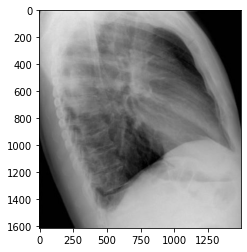

In [39]:
img = plt.imread('COVID/val/COVID/0.jpg')
plt.imshow(img)

In [40]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((36, 299, 299, 3),
 (36, 1),
 (2682, 299, 299, 3),
 (2682, 1),
 (468, 299, 299, 3),
 (468, 1))

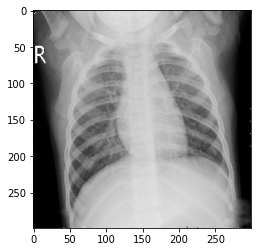

In [41]:
plt.imshow(X_train[0]/255)

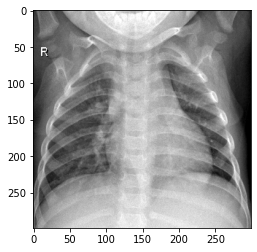

In [42]:
plt.imshow(X_val[0]/255)

In [0]:
Xtrain = X_train
Xval   = X_val
Xtest  = X_test

lb = LabelBinarizer()

labels = lb.fit_transform(Y_train)
labels = to_categorical(labels)
Ytrain = labels.astype(int)

labels = lb.fit_transform(Y_test)
labels = to_categorical(labels)
Ytest = labels.astype(int)

labels = lb.fit_transform(Y_val)
labels = to_categorical(labels)
Yval = labels.astype(int)

In [44]:
Yval[0]

array([1, 0])

In [0]:
BATCH_SIZE = 8
np.random.seed(42)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=25, 
                                   width_shift_range=0.4,
                                   height_shift_range=0.3, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(Xtrain, Ytrain, shuffle=False, batch_size=BATCH_SIZE, seed=42)

valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = train_datagen.flow(Xval, Yval, shuffle=False, batch_size=BATCH_SIZE, seed=42)

In [0]:
learning_rate = 1e-4
epochs  = 30
decay   = learning_rate/epochs
input_shape = (299, 299, 3)
nclasses = Ytrain.shape[1]

In [47]:
# Model
#base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))
base_model.reset_states()

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# Add a global spatial average pooling layer
x = base_model.output
if base_model.name == "inception_v3":
  x = BatchNormalization()(x)
  x = AveragePooling2D(pool_size=(8, 8))(x)
  x = Flatten(name="flatten")(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
elif base_model.name == 'vgg16':
  x = AveragePooling2D(pool_size=(4, 4))(x)
  x = Flatten(name="flatten")(x)
  x = Dense(64, activation="relu")(x)
  x = Dropout(0.5)(x)

logits = Dense(nclasses, activation="softmax")(x)

In [49]:
model = Model(inputs=base_model.input, outputs=logits)
model.reset_states()
# only if we want to freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Compile 
optimizer = Adam(lr=learning_rate, decay=decay)
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [50]:
batch_size = BATCH_SIZE
train_steps_per_epoch = Xtrain.shape[0]//batch_size
val_steps_per_epoch   =   Xval.shape[0]//batch_size

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
4/4 [==============================] - 61s 15s/step - loss: 0.7634 - accuracy: 0.5312 - val_loss: 0.7502 - val_accuracy: 0.4799
Epoch 2/30
4/4 [==============================] - 57s 14s/step - loss: 0.6224 - accuracy: 0.6429 - val_loss: 0.6942 - val_accuracy: 0.5366
Epoch 3/30
4/4 [==============================] - 56s 14s/step - loss: 0.6163 - accuracy: 0.7143 - val_loss: 0.6406 - val_accuracy: 0.6455
Epoch 4/30
4/4 [==============================] - 57s 14s/step - loss: 0.5641 - accuracy: 0.7500 - val_loss: 0.5952 - val_accuracy: 0.7485
Epoch 5/30
4/4 [==============================] - 57s 14s/step - loss: 0.5520 - accuracy: 0.7143 - val_loss: 0.5632 - val_accuracy: 0.7985
Epoch 6/30
4/4 [==============================] - 58s 14s/step - loss: 0.4104 - accuracy: 0.9375 - val_loss: 0.5450 - val_accuracy: 0.7974
Epoch 7/30
4/4 [==============================] - 56s 14s/step - loss: 0.4436 - accuracy: 0.8214 - val_loss: 0.5359 - val_accuracy: 0.7854
Epoch 8/30
4/4 [===========

In [0]:
model.save("model.h5")

In [52]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(Xtest, batch_size=batch_size)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(Ytest.argmax(axis=1), predIdxs,
	target_names=['NORMAL', 'COVID']))

[INFO] evaluating network...
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67       234
       COVID       0.00      0.00      0.00       234

    accuracy                           0.50       468
   macro avg       0.25      0.50      0.33       468
weighted avg       0.25      0.50      0.33       468



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(Ytest.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[234   0]
 [234   0]]
acc: 0.5000
sensitivity: 1.0000
specificity: 0.0000


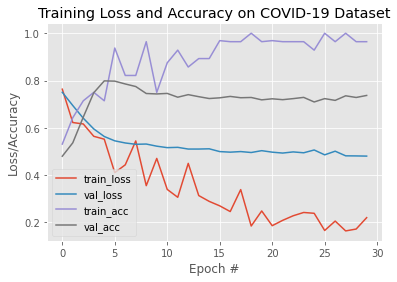

In [54]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig('Results.pdf', dpi=300)

Text(0.5, 0.98, 'COVID-19 Patients Ground Truth vs Predictions')

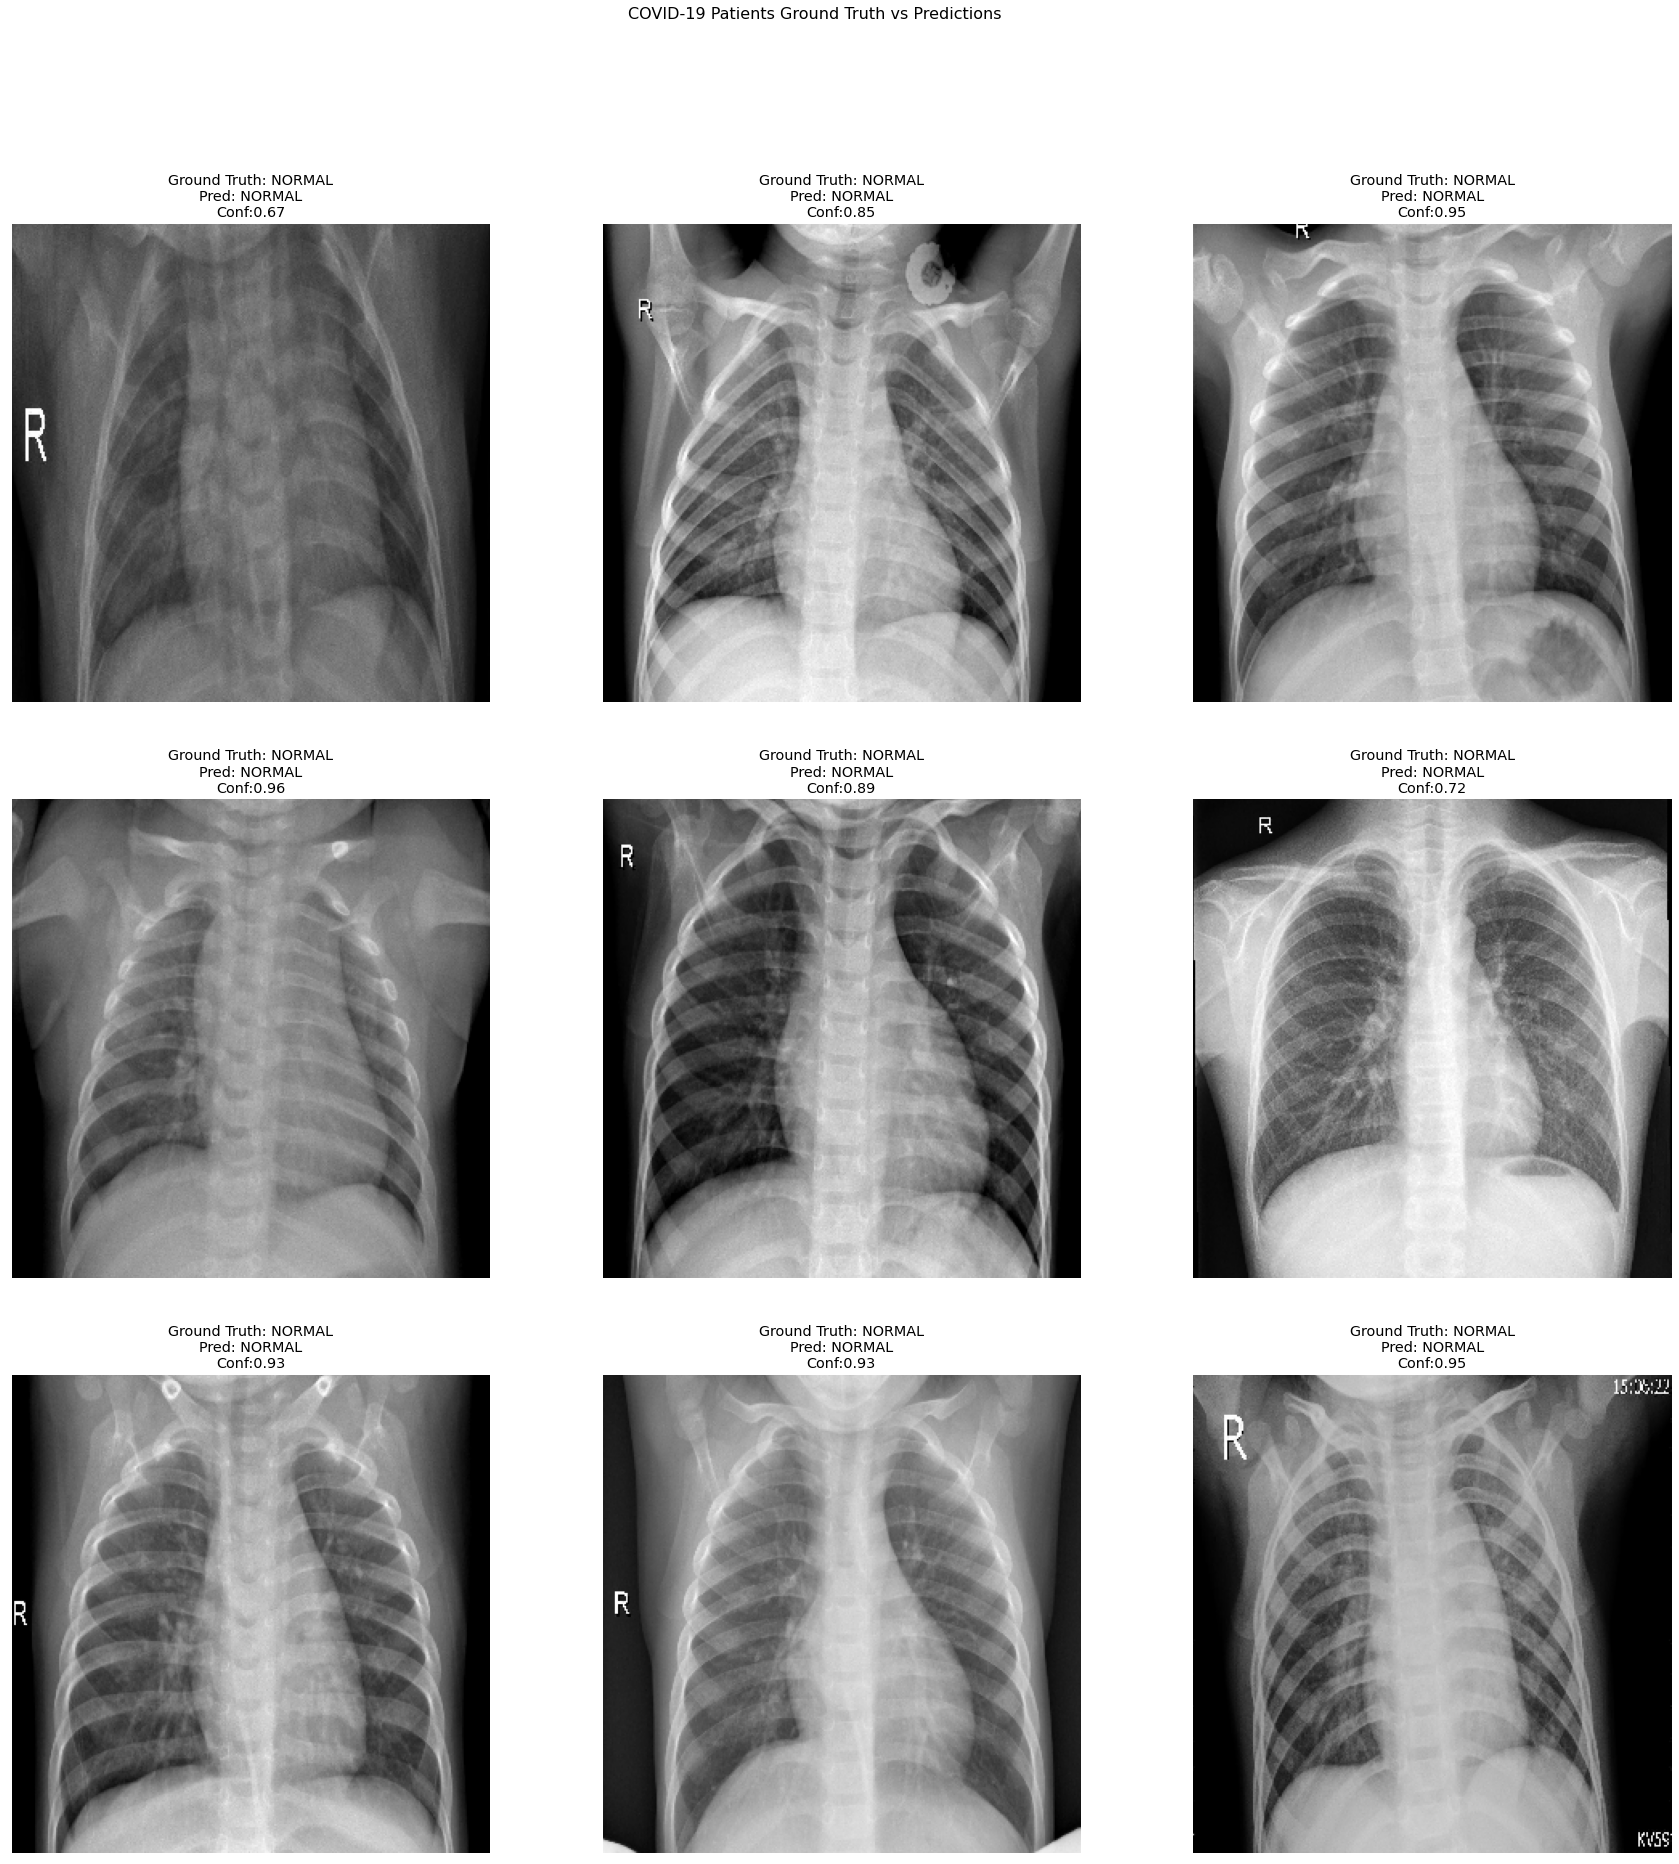

In [55]:
fig, ax = plt.subplots(figsize=(30, 30))

nrows = 3
ncols = 3

label_dict = {0:'NORMAL', 1:'COVID'}

plt.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(nrows*ncols):
  axp = plt.subplot(nrows, ncols, i + 1)
  #ix = np.random.randint(len(Ytest))

  #pred = model.predict(Xtest/255)[ix]
  pred = model.predict(Xtest/255)[i]
  lblid = np.argmax(pred)
  predlbl = label_dict.get(lblid)
  conf = round(pred[lblid], 2)
#  gtlbl = label_dict.get(np.argmax(Ytest[ix]))
  gtlbl = label_dict.get(np.argmax(Ytest[i]))
  
  plt.title("Ground Truth: " + str(gtlbl) + '\nPred: '+ str(predlbl)+'\nConf:' + str(conf))
#  plt.imshow(Xtest[ix]/255)
  plt.imshow(Xtest[i]/255)
  plt.xticks([])
  plt.yticks([])
fig.suptitle('COVID-19 Patients Ground Truth vs Predictions', fontsize=16)

In [0]:
fig.savefig('SARS-COV-2-Patients-Predictions.pdf', dpi=300)

In [0]:
def plot_one_prediction(image_path="", input_size=(299,299), model_path="", ground_truth="", lbl_dict={0:'NORMAL', 1:'SARS-CoV-2'}
):
  label      = ''
  confidence = ''

  model      = load_model(model_path)
  image      = load_img(image_path, target_size=input_size)
  img        = img_to_array(image).astype('float32')
  img        = np.array(expand_dims(img,0))/255.

  prediction = model.predict(img)[0]
  lblid      = np.argmax(prediction)
  predicted  = lbl_dict.get(lblid)
  confidence = round(prediction[lblid], 3)
  
  plt.style.use("seaborn-dark")
  plt.subplot()
  plt.title("Ground Truth: " + str(ground_truth) + '\nPred: '+ str(predicted)+'\nConf:' + str(confidence))
  plt.imshow(image)

In [61]:
files.upload()

Saving covid.jpg to covid (1).jpg


{'covid.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x07-\x05\xfa\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x

In [0]:
plot_one_prediction(image_path='covid.jpg', 
              input_size=(299,299),
              model_path='model.h5', 
              ground_truth='COVID')